## Análise de Resultados da Otimização de Prompts
### Foco: Comparativo Zero-Shot para Gemma e Sabiazinho (EVO vs. EMO)

Análise de Resultados da Otimização de Prompts

Este notebook tem como objetivo analisar os resultados dos experimentos de otimização de prompts, focando nas execuções:
- Mono-objetivo (EVO) com Gemma (zero-shot)
- Mono-objetivo (EVO) com Sabiazinho (zero-shot)
- Multi-objetivo (EMO) com sabiazinho (zero-shot)
- Multi-objetivo (EMO) com Sabiazinho (zero-shot)

**Estrutura de Diretórios Esperada:**
- Notebook em: `emo-prompt-project/results/`
- Logs em: `emo-prompt-project/logs/`
- `BASE_LOG_PATH` = `../logs`

### 1. Configurações e dados

In [1]:
%pip install datasets
%pip install matplotlib
%pip install pandas
%pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re 

In [3]:
# Configurações de plotagem
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 13
sns.set_palette("muted")

In [4]:
# Configuração de Caminhos e Carregamento de Dados

BASE_LOG_PATH = "../logs"
STRATEGY = "zero-shot" # Foco desta análise

# Configuração para nomes de modelo em caminhos e arquivos
MODEL_CONFIG = {
    "gemma": {"path_name": "gemma", "file_part": "gemma_2b", "display_name": "gemma"},
    "sabiazinho": {"path_name": "sabiazinho", "file_part": "sabiazinho_3", "display_name": "Sabiazinho"}
}

print(f"Diretório de Trabalho Atual: {os.getcwd()}")
print(f"BASE_LOG_PATH configurado como: {BASE_LOG_PATH}")
absolute_base_log_path = os.path.abspath(BASE_LOG_PATH)
print(f"Caminho absoluto para logs: {absolute_base_log_path}")
if not os.path.isdir(absolute_base_log_path):
    print(f"!!!! ATENÇÃO: A pasta BASE_LOG_PATH ('{absolute_base_log_path}') não foi encontrada. !!!!")

def load_single_experiment_data(opt_type, model_key, strategy_param, data_type="final"):
    """
    Carrega e pré-processa dados de um único experimento.
    model_key: 'gemma' ou 'sabiazinho' (chaves do MODEL_CONFIG)
    data_type: 'final' ou 'all_generations'.
    """
    if model_key not in MODEL_CONFIG:
        print(f"[load_data] ERRO: Chave de modelo '{model_key}' não encontrada em MODEL_CONFIG.")
        return pd.DataFrame()
        
    model_cfg = MODEL_CONFIG[model_key]
    model_path_name = model_cfg["path_name"]
    model_file_name_part = model_cfg["file_part"]
    model_display_name = model_cfg["display_name"]
    
    experiment_base_path = os.path.join(BASE_LOG_PATH, opt_type, model_path_name, strategy_param)
    
    df = pd.DataFrame()

    if not os.path.isdir(experiment_base_path):
        print(f"[load_data] ERRO: Diretório do experimento não encontrado: '{os.path.abspath(experiment_base_path)}'")
        return df

    if data_type == "final":
        file_path = os.path.join(experiment_base_path, "final_results.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Erro ao ler CSV '{file_path}': {e}")
        else:
            print(f"[load_data] Arquivo final não encontrado: {os.path.abspath(file_path)}")
            
    elif data_type == "all_generations":
        # Implementação para carregar dados de gerações
        all_gen_dfs = []
        if opt_type == "evo":
            gen_detail_path = os.path.join(experiment_base_path, "generation_detail")
            if not os.path.isdir(gen_detail_path):
                print(f"[load_data] ERRO: Dir de detalhes da geração EVO não encontrado: '{os.path.abspath(gen_detail_path)}'")
                return df
            pattern = os.path.join(gen_detail_path, f"results_gen_*_{model_file_name_part}_{strategy_param}.csv")
            file_list = glob.glob(pattern)
            if not file_list: print(f"[load_data] Nenhum arq de geração EVO: {pattern}")
            for f_path in file_list:
                try:
                    temp_df = pd.read_csv(f_path)
                    if 'generation' not in temp_df.columns:
                        fname = os.path.basename(f_path)
                        match = re.search(r"results_gen_(\d+)_", fname)
                        if match: temp_df['generation'] = int(match.group(1))
                    all_gen_dfs.append(temp_df)
                except Exception as e: print(f"Erro ao carregar {f_path}: {e}")
        elif opt_type == "emo":
            gen_pareto_path = os.path.join(experiment_base_path, "per_generation_pareto")
            if not os.path.isdir(gen_pareto_path):
                print(f"[load_data] ERRO: Dir de Pareto por geração EMO não encontrado: '{os.path.abspath(gen_pareto_path)}'")
                return df
            pattern = os.path.join(gen_pareto_path, "pareto_gen_*.csv")
            file_list = glob.glob(pattern)
            if not file_list: print(f"[load_data] Nenhum arq de geração EMO: {pattern}")
            for f_path in file_list:
                try:
                    temp_df = pd.read_csv(f_path)
                    fname = os.path.basename(f_path)
                    match = re.search(r"pareto_gen_(\d+)\.csv", fname)
                    if match: temp_df['generation'] = int(match.group(1))
                    all_gen_dfs.append(temp_df)
                except Exception as e: print(f"Erro ao carregar {f_path}: {e}")
        if all_gen_dfs: df = pd.concat(all_gen_dfs, ignore_index=True)
    
    if not df.empty:
        # Padronização de Nomes de Colunas
        rename_map = {}
        if 'acc' in df.columns and 'accuracy' not in df.columns:
            rename_map['acc'] = 'accuracy'
        if 'f1' in df.columns and 'f1_score' not in df.columns:
            rename_map['f1'] = 'f1_score'
        if rename_map:
            df.rename(columns=rename_map, inplace=True)
        
        # Adição de Identificadores
        df['model'] = model_display_name
        df['strategy'] = strategy_param.replace('-', ' ').capitalize()
        df['optimization_type'] = opt_type.upper()
        df['run_id'] = f"{opt_type.upper()} {model_display_name} {df['strategy'].iloc[0]}"
        
    return df

Diretório de Trabalho Atual: /home/sara/repos/emo-prompt-project/results
BASE_LOG_PATH configurado como: ../logs
Caminho absoluto para logs: /home/sara/repos/emo-prompt-project/logs


In [7]:
# ### Carregar Dados Finais dos Experimentos 
# Experimentos para esta análise focada
focused_experiments = [
    ("evo", "gemma", STRATEGY),
    ("evo", "sabiazinho", STRATEGY),
    ("emo", "gemma", STRATEGY),
    ("emo", "sabiazinho", STRATEGY),
]

final_data_map = {}
all_final_data_list = []

for opt_type, model_key, strategy_param in focused_experiments:
    run_label = f"{opt_type}_{model_key}_{strategy_param}".replace('-', '_')
    print(f"Carregando: {opt_type} - {model_key} - {strategy_param} (Final)")
    df_final = load_single_experiment_data(opt_type, model_key, strategy_param, data_type="final")
    final_data_map[run_label] = df_final
    if not df_final.empty:
        all_final_data_list.append(df_final)
    else:
        print(f"  -> Dados não carregados ou vazios para {run_label}.")

if all_final_data_list:
    df_all_final_results = pd.concat(all_final_data_list, ignore_index=True)
    print(f"\nDataFrame Mestre 'df_all_final_results' criado com shape: {df_all_final_results.shape}")
    print(df_all_final_results.groupby(['optimization_type', 'model', 'strategy']).size().reset_index(name='count'))
else:
    print("\nNenhum dado final foi carregado. Verifique os caminhos e logs.")
    df_all_final_results = pd.DataFrame()

# Acesso rápido aos dataframes individuais
evo_gemma_final = final_data_map.get(f"evo_gemma_{STRATEGY.replace('-', '_')}", pd.DataFrame())
evo_sabia_final = final_data_map.get(f"evo_sabia_{STRATEGY.replace('-', '_')}", pd.DataFrame())
emo_gemma_final = final_data_map.get(f"emo_gemma_{STRATEGY.replace('-', '_')}", pd.DataFrame())
emo_sabia_final = final_data_map.get(f"emo_sabia_{STRATEGY.replace('-', '_')}", pd.DataFrame())


Carregando: evo - gemma - zero-shot (Final)
Carregando: evo - sabiazinho - zero-shot (Final)
Carregando: emo - gemma - zero-shot (Final)
Carregando: emo - sabiazinho - zero-shot (Final)

DataFrame Mestre 'df_all_final_results' criado com shape: (25, 11)
  optimization_type       model   strategy  count
0               EMO  Sabiazinho  Zero shot      1
1               EMO       gemma  Zero shot      4
2               EVO  Sabiazinho  Zero shot     10
3               EVO       gemma  Zero shot     10


### 2. Tabela Resumo de Desempenho
Destaca os principais resultados de cada uma das 4 configurações experimentais

In [8]:
summary_list = []

if not df_all_final_results.empty:
    # Iterar sobre os grupos únicos de 'run_id' para extrair os pontos corretos
    for run_id, group_df in df_all_final_results.groupby('run_id'):
        if group_df.empty:
            print(f"Grupo {run_id} está vazio, pulando.")
            continue
            
        model = group_df['model'].iloc[0]
        strategy = group_df['strategy'].iloc[0]
        opt_type = group_df['optimization_type'].iloc[0]

        # Padronizar nomes das colunas de métricas para acesso
        acc_col = 'accuracy' if 'accuracy' in group_df.columns else None
        tok_col = 'tokens' if 'tokens' in group_df.columns else None
        f1_col = 'f1_score' if 'f1_score' in group_df.columns else None

        if not acc_col or not tok_col:
            print(f"ERRO: Colunas de acurácia ou tokens não encontradas para {run_id}. Colunas: {group_df.columns.tolist()}")
            continue

        if opt_type == "EVO":
            best_evo = group_df.sort_values(by=[acc_col, tok_col], ascending=[False, True]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Melhor Acurácia',
                'Acurácia': best_evo[acc_col],
                'Tokens': int(best_evo[tok_col]),
                'F1-Score': best_evo.get(f1_col, np.nan) if f1_col else np.nan
            })
        elif opt_type == "EMO":
            # Ponto de Maior Acurácia na Fronteira
            max_acc_emo = group_df.sort_values(by=[acc_col, tok_col], ascending=[False, True]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Max Acc (Fronteira)',
                'Acurácia': max_acc_emo[acc_col],
                'Tokens': int(max_acc_emo[tok_col]),
                'F1-Score': max_acc_emo.get(f1_col, np.nan) if f1_col else np.nan
            })
            # Ponto de Menor Tokens na Fronteira
            min_tok_emo = group_df.sort_values(by=[tok_col, acc_col], ascending=[True, False]).iloc[0]
            summary_list.append({
                'Modelo': model, 'Estratégia': strategy, 'Otimização': opt_type,
                'Destaque': 'Min Tokens (Fronteira)',
                'Acurácia': min_tok_emo[acc_col],
                'Tokens': int(min_tok_emo[tok_col]),
                'F1-Score': min_tok_emo.get(f1_col, np.nan) if f1_col else np.nan
            })
else:
    print("DataFrame df_all_final_results está vazio. Não é possível gerar tabela resumo.")

if summary_list:
    df_summary = pd.DataFrame(summary_list)
    print("\n--- Tabela Resumo de Desempenho ---")
    
    float_format_cols = ['Acurácia', 'F1-Score']
    for col in float_format_cols:
        if col in df_summary.columns:
            df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce').map('{:.4f}'.format)
    
    df_summary_sorted = df_summary.sort_values(by=['Modelo', 'Estratégia', 'Otimização', 'Destaque'])
    print(df_summary_sorted[['Modelo', 'Estratégia', 'Otimização', 'Destaque', 'Acurácia', 'Tokens', 'F1-Score']].to_string(index=False))
else:
    print("Não foi possível gerar a tabela resumo.")



--- Tabela Resumo de Desempenho ---
    Modelo Estratégia Otimização               Destaque Acurácia  Tokens F1-Score
Sabiazinho  Zero shot        EMO    Max Acc (Fronteira)   0.9500      10   0.9515
Sabiazinho  Zero shot        EMO Min Tokens (Fronteira)   0.9500      10   0.9515
Sabiazinho  Zero shot        EVO        Melhor Acurácia   0.9500      13   0.9515
     gemma  Zero shot        EMO    Max Acc (Fronteira)   0.8800      14   0.8696
     gemma  Zero shot        EMO Min Tokens (Fronteira)   0.8700      10   0.8539
     gemma  Zero shot        EVO        Melhor Acurácia   0.9000      16   0.8958


**Discussão da Tabela Resumo (para o artigo):**
* Qual modelo (Gemma/Sabia) e tipo de otimização (EVO/EMO) alcançou a maior acurácia?
* Para EMO, qual foi o menor número de tokens alcançado com uma acurácia ainda competitiva?
* Como se comparam os "melhores" pontos do EVO com os pontos extremos (max acc, min tokens) do EMO para o mesmo modelo?


### 3. Comparativo Visual: Melhor Ponto EVO vs. Fronteira EMO (por Modelo)


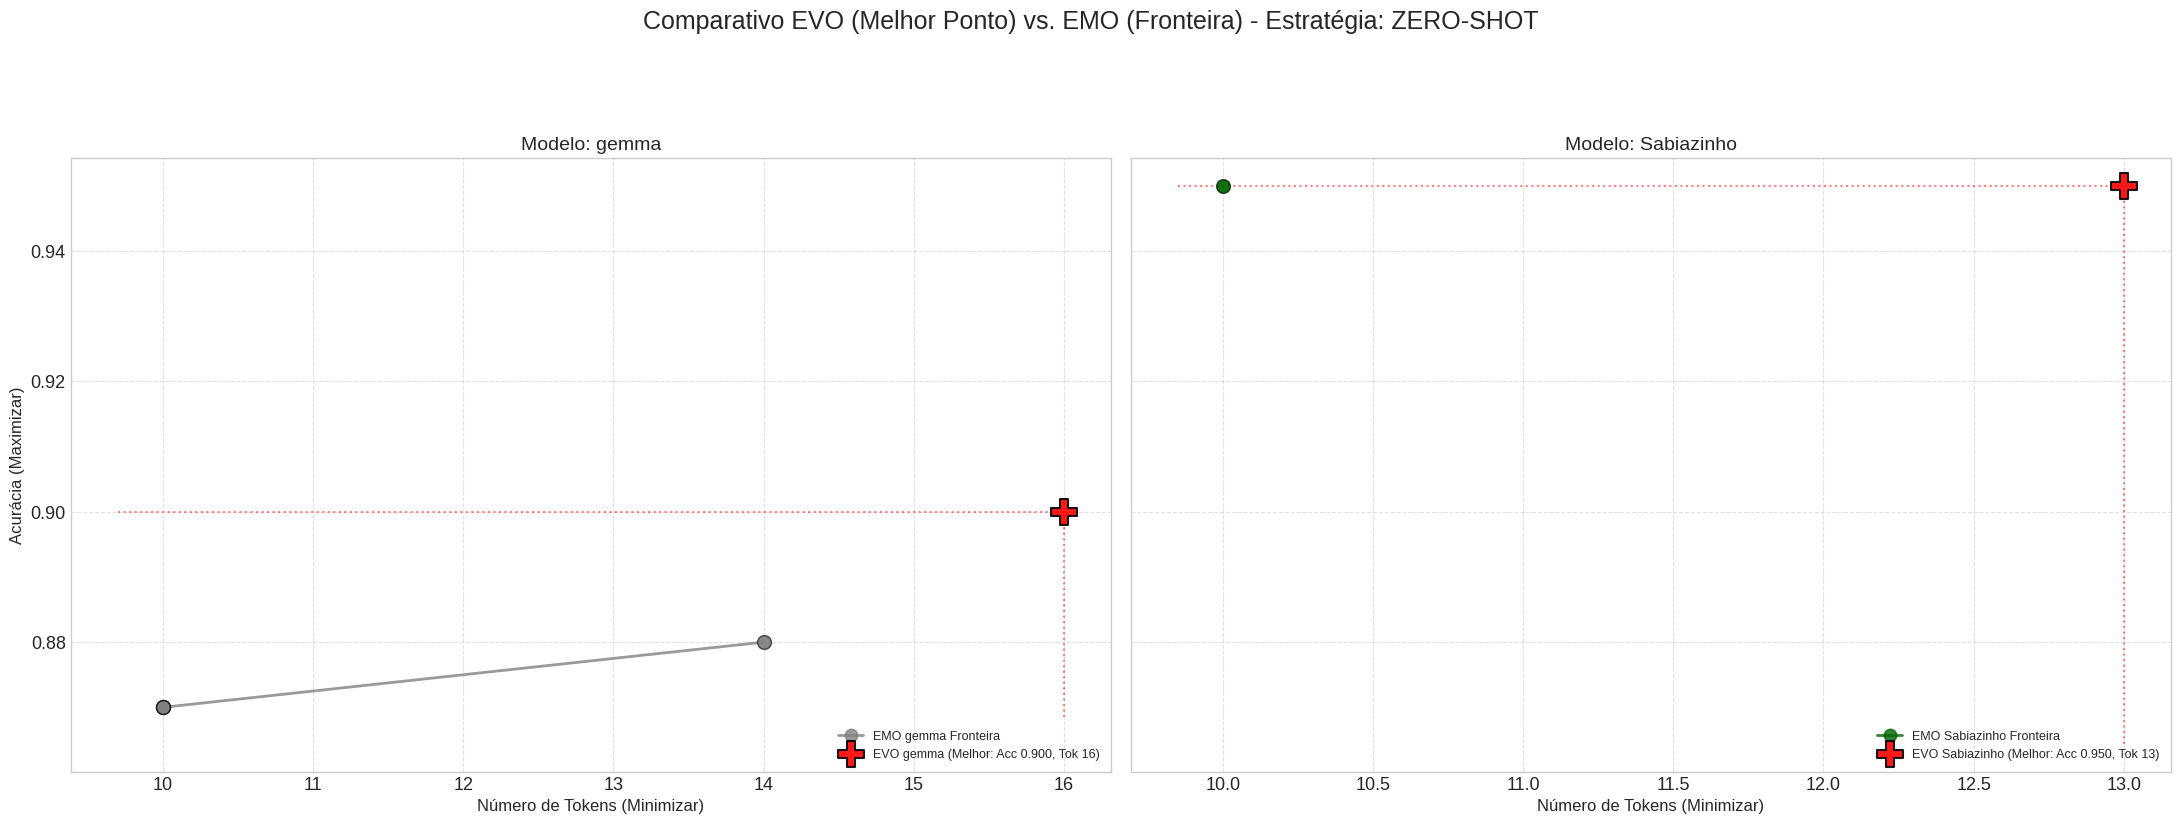

In [9]:
# Este gráfico combina as fronteiras EMO com os melhores pontos EVO para uma comparação direta.


if not df_all_final_results.empty:
    fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=True) # Um subplot por modelo
    fig.suptitle(f"Comparativo EVO (Melhor Ponto) vs. EMO (Fronteira) - Estratégia: {STRATEGY.upper()}", fontsize=18, y=1.03)

    models_to_plot = df_all_final_results['model'].unique()
    
    # Cores e marcadores
    model_colors_map = {"Gemma": "mediumblue", "Sabiazinho": "darkgreen"}
    emo_marker = 'o'
    evo_marker = 'P' # 'P' para X maiúsculo/plus, ou 'X' para X
    
    for i, model_name in enumerate(models_to_plot):
        ax = axes[i] if len(models_to_plot) > 1 else axes # Lida com caso de 1 modelo apenas

        # Dados EMO para o modelo atual
        df_emo_model = df_all_final_results[
            (df_all_final_results['model'] == model_name) & 
            (df_all_final_results['optimization_type'] == 'EMO')
        ]
        
        # Dados EVO para o modelo atual
        df_evo_model = df_all_final_results[
            (df_all_final_results['model'] == model_name) & 
            (df_all_final_results['optimization_type'] == 'EVO')
        ]

        plotted_anything_on_ax = False

        if not df_emo_model.empty and 'accuracy' in df_emo_model.columns and 'tokens' in df_emo_model.columns:
            df_emo_sorted = df_emo_model.sort_values(by='tokens')
            ax.plot(df_emo_sorted['tokens'], df_emo_sorted['accuracy'], 
                    marker=emo_marker, linestyle='-', linewidth=2, markersize=9,
                    color=model_colors_map.get(model_name, 'gray'), 
                    label=f'EMO {model_name} Fronteira', 
                    alpha=0.8, zorder=2)
            ax.scatter(df_emo_sorted['tokens'], df_emo_sorted['accuracy'], s=100, alpha=0.6, edgecolors='k', color=model_colors_map.get(model_name, 'gray'), zorder=2)
            plotted_anything_on_ax = True
        else:
            print(f"Dados EMO não encontrados ou incompletos para {model_name}")

        if not df_evo_model.empty and 'accuracy' in df_evo_model.columns and 'tokens' in df_evo_model.columns:
            best_evo = df_evo_model.sort_values(by=['accuracy', 'tokens'], ascending=[False, True]).iloc[0]
            ax.scatter(best_evo['tokens'], best_evo['accuracy'], 
                        s=350, 
                        marker=evo_marker, 
                        color='red', # Cor de destaque para o ponto EVO
                        edgecolors='black', linewidth=1.5,
                        label=f'EVO {model_name} (Melhor: Acc {best_evo["accuracy"]:.3f}, Tok {int(best_evo["tokens"])})', 
                        zorder=3, alpha=0.9)
            # Linhas pontilhadas do ponto EVO
            ax.hlines(best_evo['accuracy'], ax.get_xlim()[0], best_evo['tokens'], color='red', linestyle=':', alpha=0.5, zorder=1)
            ax.vlines(best_evo['tokens'], ax.get_ylim()[0], best_evo['accuracy'], color='red', linestyle=':', alpha=0.5, zorder=1)
            plotted_anything_on_ax = True
        else:
            print(f"Dados EVO não encontrados ou incompletos para {model_name}")

        if plotted_anything_on_ax:
            ax.set_xlabel("Número de Tokens (Minimizar)", fontsize=12)
            ax.set_ylabel("Acurácia (Maximizar)" if i == 0 else "", fontsize=12) # Label Y apenas no primeiro
            ax.set_title(f"Modelo: {model_name}", fontsize=14)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True, linestyle='--', alpha=0.6)
        else:
            ax.text(0.5, 0.5, f'Dados insuficientes para {model_name}', 
                    ha='center', va='center', transform=ax.transAxes, color='red')
            ax.set_title(f"Modelo: {model_name} - Dados Ausentes", fontsize=14)


    if len(models_to_plot) == 1 and isinstance(axes, np.ndarray): # Esconde o segundo subplot se só um modelo foi plotado
        axes[1].set_visible(False)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("DataFrame df_all_final_results está vazio. Não é possível plotar o comparativo EVO vs EMO.")


**Discussão do Gráfico Combinado EVO vs. EMO (para o artigo):**
* Para cada modelo, a abordagem EMO encontrou soluções que dominam o melhor resultado EVO? (i.e., pontos EMO "acima e à esquerda" do ponto EVO).
* O EMO oferece alternativas significativamente mais eficientes em tokens para uma acurácia similar à do melhor EVO?
* Há diferenças marcantes entre Gemma e Sabiazinho neste comparativo?


### 4. Análise Qualitativa dos Prompts Chave

In [10]:
# Exibir os prompts mais relevantes encontrados.

pd.set_option('display.max_colwidth', None)
prompts_para_artigo = []

if not df_all_final_results.empty:
    for model_name_iter in df_all_final_results['model'].unique():
        # Melhor EVO
        df_evo_model_iter = df_all_final_results[
            (df_all_final_results['model'] == model_name_iter) & 
            (df_all_final_results['optimization_type'] == 'EVO')
        ]
        if not df_evo_model_iter.empty:
            best_evo_iter = df_evo_model_iter.sort_values(by=['accuracy', 'tokens'], ascending=[False, True]).iloc[0]
            prompts_para_artigo.append({
                'Fonte': f"Melhor EVO - {model_name_iter} {STRATEGY.capitalize()}",
                'Acurácia': best_evo_iter['accuracy'],
                'Tokens': int(best_evo_iter['tokens']),
                'F1-Score': best_evo_iter.get('f1_score', np.nan),
                'Prompt': best_evo_iter['prompt']
            })

        # Pontos EMO
        df_emo_model_iter = df_all_final_results[
            (df_all_final_results['model'] == model_name_iter) & 
            (df_all_final_results['optimization_type'] == 'EMO')
        ]
        if not df_emo_model_iter.empty:
            # EMO Max Acc
            max_acc_emo_iter = df_emo_model_iter.sort_values(by=['accuracy', 'tokens'], ascending=[False, True]).iloc[0]
            prompts_para_artigo.append({
                'Fonte': f"EMO Max Acc - {model_name_iter} {STRATEGY.capitalize()}",
                'Acurácia': max_acc_emo_iter['accuracy'],
                'Tokens': int(max_acc_emo_iter['tokens']),
                'F1-Score': max_acc_emo_iter.get('f1_score', np.nan),
                'Prompt': max_acc_emo_iter['prompt']
            })
            # EMO Min Tokens
            min_tok_emo_iter = df_emo_model_iter.sort_values(by=['tokens', 'accuracy'], ascending=[True, False]).iloc[0]
            prompts_para_artigo.append({
                'Fonte': f"EMO Min Tokens - {model_name_iter} {STRATEGY.capitalize()}",
                'Acurácia': min_tok_emo_iter['accuracy'],
                'Tokens': int(min_tok_emo_iter['tokens']),
                'F1-Score': min_tok_emo_iter.get('f1_score', np.nan),
                'Prompt': min_tok_emo_iter['prompt']
            })
else:
    print("DataFrame df_all_final_results está vazio.")


if prompts_para_artigo:
    df_prompts_selecionados = pd.DataFrame(prompts_para_artigo)
    print("\n--- Prompts Selecionados para Análise Qualitativa no Artigo ---")
    
    float_format_cols_pq = ['Acurácia', 'F1-Score']
    for col in float_format_cols_pq:
        if col in df_prompts_selecionados.columns:
            # Erros viram NaN, depois string 'nan'
            df_prompts_selecionados[col] = pd.to_numeric(df_prompts_selecionados[col], errors='coerce').map(lambda x: f'{x:.4f}' if pd.notnull(x) else 'N/A')

    print(df_prompts_selecionados.sort_values(by=['Fonte']).to_string(index=False))
else:
    print("Não foi possível gerar a lista de prompts para análise qualitativa.")
    
pd.reset_option('display.max_colwidth')


--- Prompts Selecionados para Análise Qualitativa no Artigo ---
                                Fonte Acurácia  Tokens F1-Score                                                                            Prompt
   EMO Max Acc - Sabiazinho Zero-shot   0.9500      10   0.9515                          "Classifique este comentário como positivo ou negativo."
        EMO Max Acc - gemma Zero-shot   0.8800      14   0.8696 Decida se a crítica abaixo expressa uma visão favorável ou desfavorável do filme.
EMO Min Tokens - Sabiazinho Zero-shot   0.9500      10   0.9515                          "Classifique este comentário como positivo ou negativo."
     EMO Min Tokens - gemma Zero-shot   0.8700      10   0.8539                          "Classifique este comentário como positivo ou negativo."
    Melhor EVO - Sabiazinho Zero-shot   0.9500      13   0.9515                     "Classifique a resenha abaixo como 'positivo' ou 'negativo':"
         Melhor EVO - gemma Zero-shot   0.9000      16   0.


**Discussão da Análise Qualitativa (para o artigo):**
* Apresente os exemplos de prompts.
* Discuta suas características: são concisos? Usam linguagem imperativa? Contêm palavras-chave específicas?
* Existem diferenças notáveis nos tipos de prompts que funcionam bem para Gemma vs. Sabiazinho?
* O processo de otimização gerou prompts que você não teria pensado manualmente?


1. Discussão Geral e Conclusões para o Artigo

Com base na tabela resumo, no gráfico comparativo EVO vs. EMO e na análise qualitativa dos prompts:

1.  **Desempenho Geral dos Modelos (Gemma vs. Sabiazinho) na Estratégia Zero-Shot:**
    * Qual modelo alcançou maior acurácia e/ou melhor eficiência de tokens?
    * *Seu insight anterior: Sabiazinho parece dominar.* Confirme com os dados de Zero-Shot. Discuta a esparsidade da fronteira do Sabiazinho versus a do Gemma.

2.  **Comparação das Abordagens de Otimização (EVO vs. EMO) para Zero-Shot:**
    * A otimização multiobjetivo (EMO) ofereceu vantagens claras sobre a mono-objetivo (EVO)? (Ex: Encontrou prompts mais curtos com acurácia similar ou superior? Encontrou prompts com acurácia superior?)
    * Para qual modelo a abordagem EMO foi particularmente benéfica?

3.  **Características dos Prompts Otimizados:**
    * Quais padrões emergem dos prompts de melhor desempenho para cada modelo?
    * A otimização tendeu a simplificar ou a complexificar os prompts iniciais?

4.  **Principais Contribuições e Implicações:**
    * (Resuma as descobertas mais importantes do seu estudo para a área de otimização de prompts).

5.  **Limitações e Trabalhos Futuros:**
    * (Considere as limitações da sua análise focada (apenas zero-shot) e como os resultados de few-shot (a serem analisados depois) podem complementar ou alterar essas conclusões. Sugira próximos passos.)


### Evolução da Fronteira de Pareto 

In [ ]:
# Evolução da Fronteira de Pareto para GEMMA

# Certifique-se que estas variáveis com nomes de colunas estão definidas corretamente:
# ACC_COLUMN_EMO, TOKENS_COLUMN_EMO
# Exemplo:
# ACC_COLUMN_EMO = 'accuracy' 
# TOKENS_COLUMN_EMO = 'tokens'

if 'emo_gemma_zero_gens' in locals() and not emo_gemma_zero_gens.empty:
    plt.figure(figsize=(12, 8))
    # Pega todas as gerações únicas e ordena
    generations_gemma_emo = sorted(emo_gemma_zero_gens['generation'].unique())
    
    # Seleciona um subconjunto de gerações para plotar e evitar poluição visual
    # Ex: primeira, algumas intermediárias e a última.
    if len(generations_gemma_emo) > 5: 
        # Plotar no máximo 5 frentes: primeira, última e 3 intermediárias equidistantes
        indices_to_plot = np.unique(np.linspace(0, len(generations_gemma_emo) - 1, 5, dtype=int))
        generations_to_plot_gemma = [generations_gemma_emo[i] for i in indices_to_plot]
    else:
        generations_to_plot_gemma = generations_gemma_emo
        
    palette_gens_gemma = sns.color_palette("coolwarm_r", n_colors=len(generations_to_plot_gemma))

    for i, gen in enumerate(generations_to_plot_gemma):
        gen_data = emo_gemma_zero_gens[emo_gemma_zero_gens['generation'] == gen].sort_values(by=TOKENS_COLUMN_EMO)
        if not gen_data.empty:
            # Plotar linha e pontos
            plt.plot(gen_data[TOKENS_COLUMN_EMO], gen_data[ACCURACY_COLUMN_EMO], 
                    marker='o', linestyle='-',
                    markersize=6 + i*0.5, # Pontos de gerações mais recentes um pouco maiores
                    alpha=0.5 + i*0.1, # Gerações mais recentes mais opacas
                    color=palette_gens_gemma[i], 
                    label=f'Geração {gen}')
    
    plt.xlabel(f'Tokens ({TOKENS_COLUMN_EMO.capitalize()}) - Menor é Melhor')
    plt.ylabel(f'Acurácia ({ACCURACY_COLUMN_EMO.capitalize()}) - Maior é Melhor')
    plt.title(f'Evolução da Fronteira de Pareto - EMO Gemma ({STRATEGY.upper()})')
    plt.legend(title='Geração', loc='best', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"Não há dados de geração para EMO Gemma ({STRATEGY}) para plotar a evolução da fronteira.")

In [33]:
# Evolução da Fronteira de Pareto para Sabiazinho

# Certifique-se que estas variáveis com nomes de colunas estão definidas corretamente:
# ACC_COLUMN_EMO, TOKENS_COLUMN_EMO
# Exemplo:
# ACC_COLUMN_EMO = 'accuracy' 
# TOKENS_COLUMN_EMO = 'tokens'

if 'emo_sabiazinho_zero_gens' in locals() and not emo_sabiazinho_zero_gens.empty:
    plt.figure(figsize=(12, 8))
    # Pega todas as gerações únicas e ordena
    generations_sabiazinho_emo = sorted(emo_sabiazinho_zero_gens['generation'].unique())
    
    # Seleciona um subconjunto de gerações para plotar e evitar poluição visual
    # Ex: primeira, algumas intermediárias e a última.
    if len(generations_sabiazinho_emo) > 5: 
        # Plotar no máximo 5 frentes: primeira, última e 3 intermediárias equidistantes
        indices_to_plot = np.unique(np.linspace(0, len(generations_sabiazinho_emo) - 1, 5, dtype=int))
        generations_to_plot_sabiazinho = [generations_sabiazinho_emo[i] for i in indices_to_plot]
    else:
        generations_to_plot_sabiazinho = generations_sabiazinho_emo
        
    palette_gens_sabiazinho = sns.color_palette("coolwarm_r", n_colors=len(generations_to_plot_sabiazinho))

    for i, gen in enumerate(generations_to_plot_sabiazinho):
        gen_data = emo_sabiazinho_zero_gens[emo_sabiazinho_zero_gens['generation'] == gen].sort_values(by=TOKENS_COLUMN_EMO)
        if not gen_data.empty:
            # Plotar linha e pontos
            plt.plot(gen_data[TOKENS_COLUMN_EMO], gen_data[ACCURACY_COLUMN_EMO], 
                    marker='o', linestyle='-',
                    markersize=6 + i*0.5, # Pontos de gerações mais recentes um pouco maiores
                    alpha=0.5 + i*0.1, # Gerações mais recentes mais opacas
                    color=palette_gens_sabiazinho[i], 
                    label=f'Geração {gen}')
    
    plt.xlabel(f'Tokens ({TOKENS_COLUMN_EMO.capitalize()}) - Menor é Melhor')
    plt.ylabel(f'Acurácia ({ACCURACY_COLUMN_EMO.capitalize()}) - Maior é Melhor')
    plt.title(f'Evolução da Fronteira de Pareto - EMO Sabiazinho ({STRATEGY.upper()})')
    plt.legend(title='Geração', loc='best', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"Não há dados de geração para EMO sabiazinho ({STRATEGY}) para plotar a evolução da fronteira.")

Não há dados de geração para EMO sabiazinho (zero-shot) para plotar a evolução da fronteira.


In [34]:
# %% [code]
# Plot para EMO Sabiazinho (CORRIGIDO O NOME DA VARIÁVEL)

# Certifique-se que estas variáveis com nomes de colunas estão definidas corretamente:
# ACC_COLUMN_EMO, TOKENS_COLUMN_EMO
# Exemplo:
# ACC_COLUMN_EMO = 'accuracy' 
# TOKENS_COLUMN_EMO = 'tokens'

# AQUI ESTÁ A MUDANÇA PRINCIPAL: use 'emo_sabia_zero_gens'
if 'emo_sabia_zero_gens' in locals() and not emo_sabia_zero_gens.empty:
    plt.figure(figsize=(12, 8))
    # Pega todas as gerações únicas e ordena
    generations_sabia_emo = sorted(emo_sabia_zero_gens['generation'].unique()) # Usa 'emo_sabia_zero_gens'
    
    if len(generations_sabia_emo) > 5: 
        indices_to_plot = np.unique(np.linspace(0, len(generations_sabia_emo) - 1, 5, dtype=int))
        generations_to_plot_sabia = [generations_sabia_emo[i] for i in indices_to_plot]
    else:
        generations_to_plot_sabia = generations_sabia_emo
        
    palette_gens_sabia = sns.color_palette("Oranges_r", n_colors=len(generations_to_plot_sabia)) # Paleta diferente

    for i, gen in enumerate(generations_to_plot_sabia):
        gen_data = emo_sabia_zero_gens[emo_sabia_zero_gens['generation'] == gen].sort_values(by=TOKENS_COLUMN_EMO) # Usa 'emo_sabia_zero_gens'
        if not gen_data.empty:
            plt.plot(gen_data[TOKENS_COLUMN_EMO], gen_data[ACCURACY_COLUMN_EMO], 
                     marker='x', # Marcador diferente para Sabia
                     linestyle='-',
                     markersize=6 + i*0.5, 
                     alpha=0.5 + i*0.1, 
                     color=palette_gens_sabia[i], 
                     label=f'Geração {gen}')
    
    plt.xlabel(f'Tokens ({TOKENS_COLUMN_EMO.capitalize()}) - Menor é Melhor')
    plt.ylabel(f'Acurácia ({ACCURACY_COLUMN_EMO.capitalize()}) - Maior é Melhor')
    plt.title(f'Evolução da Fronteira de Pareto - EMO Sabiazinho ({STRATEGY.upper()})') # Título ajustado
    plt.legend(title='Geração', loc='best', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"Não há dados de geração para EMO Sabiazinho ({STRATEGY}) para plotar a evolução da fronteira (variável 'emo_sabia_zero_gens' não encontrada ou vazia).")

Não há dados de geração para EMO Sabiazinho (zero-shot) para plotar a evolução da fronteira (variável 'emo_sabia_zero_gens' não encontrada ou vazia).


Dados de geração EMO Gemma não carregados.
Dados de geração EMO Sabiazinho não carregados.


/tmp/ipykernel_50410/1655417859.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipykernel_50410/1655417859.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


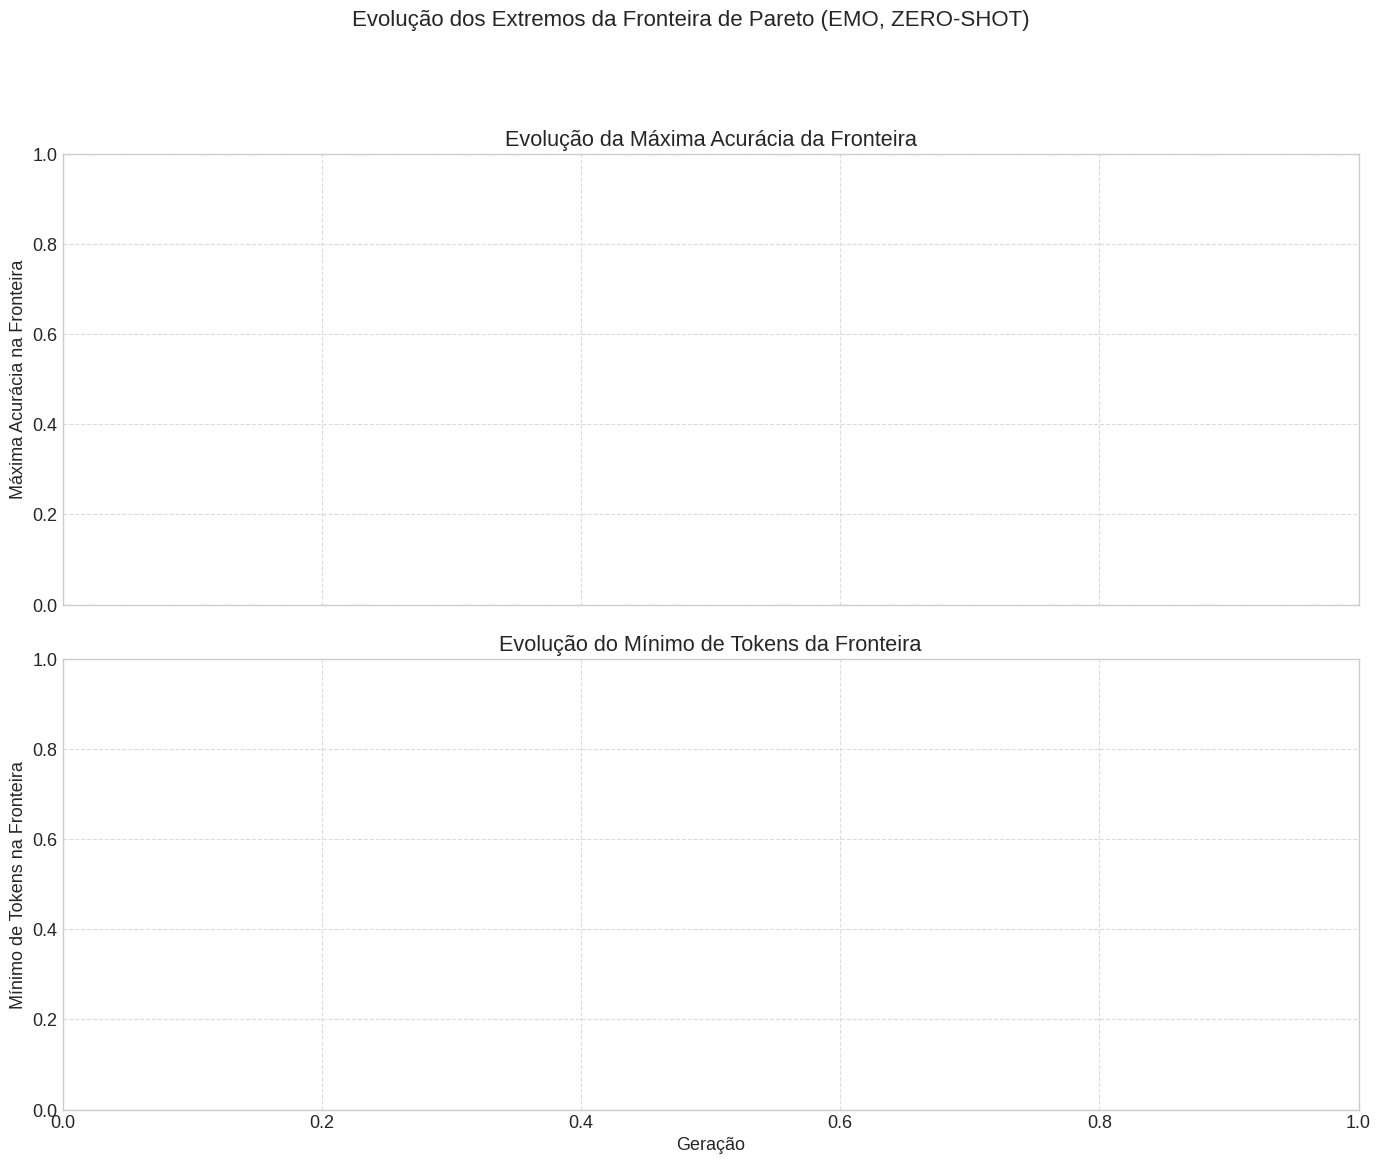

In [35]:
# Evolução dos Pontos Extremos da Fronteira de Pareto (por Modelo)

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'Evolução dos Extremos da Fronteira de Pareto (EMO, {STRATEGY.upper()})', fontsize=16, y=1.0)

# Modelo Gemma
if 'emo_gemma_zero_gens' in locals() and not emo_gemma_zero_gens.empty:
    if ACCURACY_COLUMN_EMO in emo_gemma_zero_gens.columns and TOKENS_COLUMN_EMO in emo_gemma_zero_gens.columns:
        gemma_max_acc_per_gen = emo_gemma_zero_gens.groupby('generation')[ACCURACY_COLUMN_EMO].max()
        gemma_min_tokens_per_gen = emo_gemma_zero_gens.groupby('generation')[TOKENS_COLUMN_EMO].min()
        
        gemma_max_acc_per_gen.plot(ax=axes[0], label='Gemma - Max Acurácia na Fronteira', marker='o', color='blue')
        gemma_min_tokens_per_gen.plot(ax=axes[1], label='Gemma - Min Tokens na Fronteira', marker='o', color='blue')
    else:
        print(f"Colunas '{ACCURACY_COLUMN_EMO}' ou '{TOKENS_COLUMN_EMO}' ausentes em emo_gemma_zero_gens.")
else:
    print("Dados de geração EMO Gemma não carregados.")

# Modelo Sabiazinho
if 'emo_sabia_zero_gens' in locals() and not emo_sabia_zero_gens.empty:
    if ACCURACY_COLUMN_EMO in emo_sabia_zero_gens.columns and TOKENS_COLUMN_EMO in emo_sabia_zero_gens.columns:
        sabia_max_acc_per_gen = emo_sabia_zero_gens.groupby('generation')[ACCURACY_COLUMN_EMO].max()
        sabia_min_tokens_per_gen = emo_sabia_zero_gens.groupby('generation')[TOKENS_COLUMN_EMO].min()
        
        sabia_max_acc_per_gen.plot(ax=axes[0], label='Sabiazinho - Max Acurácia na Fronteira', marker='x', color='green')
        sabia_min_tokens_per_gen.plot(ax=axes[1], label='Sabiazinho - Min Tokens na Fronteira', marker='x', color='green')
    else:
        print(f"Colunas '{ACCURACY_COLUMN_EMO}' ou '{TOKENS_COLUMN_EMO}' ausentes em emo_sabia_zero_gens.")
else:
    print("Dados de geração EMO Sabiazinho não carregados.")

axes[0].set_ylabel('Máxima Acurácia na Fronteira')
axes[0].set_title('Evolução da Máxima Acurácia da Fronteira')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].set_xlabel('Geração')
axes[1].set_ylabel('Mínimo de Tokens na Fronteira')
axes[1].set_title('Evolução do Mínimo de Tokens da Fronteira')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Visualização das Fronteiras de Pareto Finais

#### "Acurácia por Densidade" - Densidade de Soluções no Espaço Objetivo (EMO)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle(f'Densidade de Soluções na Fronteira Final (EMO, {STRATEGY})', fontsize=16)

if not emo_gemma_zero_final.empty:
    sns.kdeplot(data=emo_gemma_zero_final, x="tokens", y="acc", fill=True, thresh=0.05, cmap="viridis", ax=axes[0])
    axes[0].scatter(emo_gemma_zero_final['tokens'], emo_gemma_zero_final['acc'], s=30, color='white', alpha=0.7, edgecolors='k')
    axes[0].set_title(f'EMO Gemma {STRATEGY}')
    axes[0].set_xlabel('Tokens')
    axes[0].set_ylabel('Acurácia')
    axes[0].grid(True)

if not emo_sabia_zero_final.empty:
    sns.kdeplot(data=emo_sabia_zero_final, x="tokens", y="acc", fill=True, thresh=0.05, cmap="viridis", ax=axes[1])
    axes[1].scatter(emo_sabia_zero_final['tokens'], emo_sabia_zero_final['acc'], s=30, color='white', alpha=0.7, edgecolors='k')
    axes[1].set_title(f'EMO Sabiazinho {STRATEGY}')
    axes[1].set_xlabel('Tokens')
    axes[1].set_ylabel('') # Acurácia (compartilhado)
    axes[1].grid(True)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# %% [code]
# --- Comparação para Gemma ---
if 'evo_gemma_zero_final' in locals() and not evo_gemma_zero_final.empty and \
   'emo_gemma_zero_final' in locals() and not emo_gemma_zero_final.empty:

    # Garante que best_evo_gemma é uma Series
    best_evo_gemma_df = evo_gemma_zero_final.sort_values(by=[ACC_COLUMN_EVO, TOKENS_COLUMN_EVO], ascending=[False, True])
    if not best_evo_gemma_df.empty:
        best_evo_gemma_series = best_evo_gemma_df.iloc[0] # Pega a primeira linha como Series

        plot_evo_emo_comparison_with_dominance(
            emo_df=emo_gemma_zero_final.copy(), # Passa uma cópia para evitar modificações no original
            evo_best_series=best_evo_gemma_series,
            emo_label_str='EMO Gemma',
            evo_label_str='EVO Gemma',
            model_name_str='Gemma',
            strategy_str=STRATEGY,
            acc_col_emo_str=ACC_COLUMN_EMO,
            tok_col_emo_str=TOKENS_COLUMN_EMO,
            acc_col_evo_str=ACC_COLUMN_EVO,
            tok_col_evo_str=TOKENS_COLUMN_EVO
        )
    else:
        print("DataFrame evo_gemma_zero_final está vazio após ordenação, não é possível obter a melhor solução EVO para Gemma.")
else:
    print("Aviso: DataFrame evo_gemma_zero_final ou emo_gemma_zero_final não estão definidos ou estão vazios. Pulando plot para Gemma.")

# --- Comparação para Sabiazinho ---
# (Faça o mesmo para Sabiazinho)
if 'evo_sabia_zero_final' in locals() and not evo_sabia_zero_final.empty and \
   'emo_sabia_zero_final' in locals() and not emo_sabia_zero_final.empty:

    best_evo_sabia_df = evo_sabia_zero_final.sort_values(by=[ACC_COLUMN_EVO, TOKENS_COLUMN_EVO], ascending=[False, True])
    if not best_evo_sabia_df.empty:
        best_evo_sabia_series = best_evo_sabia_df.iloc[0]

        plot_evo_emo_comparison_with_dominance(
            emo_df=emo_sabia_zero_final.copy(),
            evo_best_series=best_evo_sabia_series,
            emo_label_str='EMO Sabiazinho',
            evo_label_str='EVO Sabiazinho',
            model_name_str='Sabiazinho',
            strategy_str=STRATEGY,
            acc_col_emo_str=ACC_COLUMN_EMO,
            tok_col_emo_str=TOKENS_COLUMN_EMO,
            acc_col_evo_str=ACC_COLUMN_EVO,
            tok_col_evo_str=TOKENS_COLUMN_EVO
        )
    else:
        print("DataFrame evo_sabia_zero_final está vazio após ordenação, não é possível obter a melhor solução EVO para Sabiazinho.")
else:
    print("Aviso: DataFrame evo_sabia_zero_final ou emo_sabia_zero_final não estão definidos ou estão vazios. Pulando plot para Sabiazinho.")

In [ ]:
# %% [code]
# Comparar Acurácia Final: EVO Gemma vs. EMO Gemma (Fronteira)

# Certifique-se que os DataFrames estão carregados e não vazios
# e que ACC_COLUMN_EVO e ACC_COLUMN_EMO estão corretos.
plot_comparativo_densidade(
    metric_col_df1=ACC_COLUMN_EVO, 
    df1=evo_gemma_zero_final, 
    label1=f"EVO Gemma ({STRATEGY}) - Pop. Final", 
    metric_col_df2=ACC_COLUMN_EMO, 
    df2=emo_gemma_zero_final, 
    label2=f"EMO Gemma ({STRATEGY}) - Fronteira Final",
    title_metric_name="Acurácia" # Nome da métrica para o título e eixo X
)



In [ ]:
# Faça o mesmo para Tokens, e depois repita para o Sabiazinho:
plot_comparativo_densidade(
    metric_col_df1=TOKENS_COLUMN_EVO, 
    df1=evo_gemma_zero_final, 
    label1=f"EVO Gemma ({STRATEGY}) - Pop. Final", 
    metric_col_df2=TOKENS_COLUMN_EMO, 
    df2=emo_gemma_zero_final, 
    label2=f"EMO Gemma ({STRATEGY}) - Fronteira Final",
    title_metric_name="Número de Tokens"
)



In [ ]:
plot_comparativo_densidade(
    metric_col_df1=ACC_COLUMN_EVO, 
    df1=evo_sabia_zero_final, 
    label1=f"EVO Sabia ({STRATEGY}) - Pop. Final", 
    metric_col_df2=ACC_COLUMN_EMO, 
    df2=emo_sabia_zero_final, 
    label2=f"EMO Sabia ({STRATEGY}) - Fronteira Final",
    title_metric_name="Acurácia"
)



In [ ]:
plot_comparativo_densidade(
    metric_col_df1=TOKENS_COLUMN_EVO, 
    df1=evo_sabia_zero_final, 
    label1=f"EVO Sabiazinho ({STRATEGY}) - Pop. Final", 
    metric_col_df2=TOKENS_COLUMN_EMO, 
    df2=emo_sabia_zero_final, 
    label2=f"EMO Sabiazinho ({STRATEGY}) - Fronteira Final",
    title_metric_name="Número de Tokens"
)
